<a href="https://colab.research.google.com/github/iam1997/Project-03-Chevron-Equipment-Maintenance-Data-/blob/main/Project_03_Chevron_Equipment_Maintenance_Data__VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instructions

#### Given the data file "WorkOders15_18 Corrective.csv ":
- Recode label data
- Determine which factors influence MTTF (mean time to failure)
- Determine 20/80 for equipment failures (type, manufacturer, etc)
- Show descriptive statistics for MTTF and repair times
- Using machine learning predict extreme repair events (too soon, too long to repair, too costly)

#### Methodology:
- Carry out PCA. Summarize findings looking for relationship for variables time between failures (MTTF), repair time, cost
- Give statistics about time between failures (MTTF), repair time, cost (Including histograms)
- Do some math to find 20/80's of those variables
- Create classes and carry out machine learning to determine what causes those rather extreme cases
    
#### Deliver:
- Statistical analysis (mean, std dev, max, min, etc.) for time between failures (MTTF), repair time, cost
- Principal component analysis answering what variables influence time between failures (MTTF), repair time, cost
- Machine learning to predict time between failures (MTTF), repair time, cost after having established some thresholds. - There are suggestions but please set your own thresholds:
    
    ##### Duration
The threshold was 7 days for all jobs, which is 95% percentile and 6 days for corrective jobs, which is also 95% percentile. 
A Duration of less than the threshold is label as 0. A duration above the threshold was labelled as 1 
    ##### Total cost
The threshold was established at $6520.00 which is 99% percentile (above is 1, below is 0) and $6700.00 for corrective jobs (99% percentile)
    ##### Time between reports
For the same equipment the threshold was set to 40 days for both general and corrective reports 63% percentile general, 42% corrective, above is 0, below is 1

In [1]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [2]:
# -----------------------------------------------------------------------------------------------------------------
# Import libraries
# -----------------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn import preprocessing
import catboost
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files
import io
import matplotlib.pyplot as plt

FieldProductionTeam,

EquipmentType,

EquipmentClass,

EquipmentCriticality,

Priority, 

Cause,

FailureReason,

Duration, 

GrossProductionLoss,

AffectedProduction,

IsAffectingProduction,

TotalCost,

Manufacturer,

ActualDuration, 

TBF,

TBF_Equipment




In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Open the dataset
# -----------------------------------------------------------------------------------------------------------------
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['WorkOders15_18 Corrective (1).csv']))

Saving WorkOders15_18 Corrective (1).csv to WorkOders15_18 Corrective (1).csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Save the dataset as .xlsx
# -----------------------------------------------------------------------------------------------------------------
#dataset.to_excel(r'C:\Users\Manuel Wereb\Dropbox\Studium\Semester\TEC de Monterrey\Data Science and Big Data Analytics\Classworks\WorkOders15_18 Corrective_10Lines.xlsx')

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Drop columns which contain always the same value or always a different value to reduce the size of the dataset
# -----------------------------------------------------------------------------------------------------------------
datasetFiltered = pd.DataFrame(data=None, columns=None)
for column in dataset.columns:
    print('{0} has {1} rows and {2} different values'.format(column, len(dataset.index), len(dataset[column].unique())))
    if len(dataset[column].unique()) != 1 and len(dataset[column].unique()) != len(dataset.index):
        datasetFiltered[column] = dataset[column]
    else:
        print('--> {0} is dropped'.format(column))

WorkOrder has 89480 rows and 89480 different values
--> WorkOrder is dropped
FieldProductionTeam has 89480 rows and 56 different values
Comment has 89480 rows and 87299 different values
EquipmentCode has 89480 rows and 45782 different values
EquipmentRollupCode has 89480 rows and 45586 different values
EquipmentDescription has 89480 rows and 43328 different values
EquipmentType has 89480 rows and 4 different values
EquipmentClass has 89480 rows and 332 different values
EquipmentCriticality has 89480 rows and 8 different values
StatusCode has 89480 rows and 2 different values
StatusDescription has 89480 rows and 2 different values
StatusShortDescription has 89480 rows and 2 different values
Priority has 89480 rows and 11 different values
WOType has 89480 rows and 1 different values
--> WOType is dropped
JobType has 89480 rows and 1 different values
--> JobType is dropped
Action has 89480 rows and 35 different values
Requirement has 89480 rows and 21 different values
Cause has 89480 rows

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Drop the column StatusDescription and StatusShortDescription because it contains exact the same statement as StatusCode
# -----------------------------------------------------------------------------------------------------------------    
datasetFiltered['StatusDescription'] = datasetFiltered['StatusDescription'].replace(['C - Closed - Sent to History', 'D - Waiting Work Order Completion'], ['C', 'D'])
comparisonColumn = np.where(datasetFiltered['StatusCode'] == datasetFiltered['StatusDescription'], True, False)
if False not in comparisonColumn:
    datasetFiltered = datasetFiltered.drop('StatusDescription', axis=1)
    
datasetFiltered['StatusShortDescription'] = datasetFiltered['StatusShortDescription'].replace(['Closed(C)', 'Complete(D)'], ['C', 'D'])
comparisonColumn = np.where(datasetFiltered['StatusCode'] == datasetFiltered['StatusShortDescription'], True, False)
if False not in comparisonColumn:
    datasetFiltered = datasetFiltered.drop('StatusShortDescription', axis=1)

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Count different values in the columns of the dataset
# -----------------------------------------------------------------------------------------------------------------    
datasetFiltered['Priority'] = datasetFiltered['Priority'].replace([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])
for column in datasetFiltered.columns:
    print(datasetFiltered[column].value_counts())
    print('\n')

KR                 16215
MS                  5984
MCELROY             4761
EUNICE              4731
BUCKEYE             4138
CY                  4013
VAN                 2977
HOBBS               2769
CARLSBAD            2586
CARTHAGE            2555
ODESSAEAST          2541
ODESSAWEST          2422
CONGER              2282
SA                  2233
FTSTOCKTON          2097
LH                  2039
CO                  2008
VEALMOOR            1934
MABEE               1884
HEADLEEGAS          1774
JSM                 1703
RANGELY             1655
ANDREWS             1279
BGF                 1251
DOLLARHIDE          1072
TAH                  914
PICEANCE             883
BIGLAKE              762
GW                   694
PET                  681
BUCKEYEPLANT         649
SANJUAN              577
GEN                  551
SF                   513
WHARTON              511
None                 493
DOLLARHIDEPLANT      453
OZONA                427
CAYUGA               378
TS                   314


In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Drop non-informative columns to reduce the size of the dataset
# -----------------------------------------------------------------------------------------------------------------    
datasetFiltered = datasetFiltered.drop(['Comment', 'EquipmentCode', 'EquipmentRollupCode', 'EquipmentDescription', 'StatusCode', 'Action', 'Requirement', 'LaborCost', 'MaterialCost', 'Assigned', 'Trade', 'TradeGroup', 'SupervisorRole', 'Model', 'Safety', 'Reopened',  'CreatedBy', 'UpdatedBy', 'CreatedDate', 'UpdatedDate', 'ReportDate', 'ReportMonth', 'ReportWeekDay', 'TargetDate', 'SchEndDate', 'ScheduleCompliant',  'CompletedDate', 'CompletedMonth', 'CompletedWeekDay'], axis=1)
datasetFiltered                                        

,FieldProductionTeam,EquipmentType,EquipmentClass,EquipmentCriticality,Priority,Cause,FailureReason,Duration,GrossProductionLoss,AffectedProduction,IsAffectingProduction,TotalCost,Manufacturer,ActualDuration,TBF,TBF_Equipment
0,RANGELY,System,SE - Battery,NA - Not Applicable,2,Plugged,Pipe - Piping,1,0,0,No,1700,NOTAPPLICABLE,-1,0,4.0
1,VAN,System,Line - Production Flowline,3 - Low,4,Missing,"Assembly - Pump, Chemical",1,0,0,No,700,NOTAPPLICABLE,3,0,NaN
2,VAN,Asset,Pumping Unit,3 - Low,3,Loose,Component - Belt,1,0,4,Yes,300,LUFKIN,19,0,1.0
3,VAN,System,SE - Field,NA - Not Applicable,3,Improper Fit,Pipe - Piping,1,0,0,No,457,NOTAPPLICABLE,19,0,0.0
4,VAN,System,SE - Field,NA - Not Applicable,3,Fouling,"Pump, other",1,0,0,No,483,NOTAPPLICABLE,19,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89475,KR,Position,Pump - Centrifugal Single Stage,3 - Low,3,Flow Cut / Erosion / Wear,"Component - Rings, Carbon",1,0,0,No,0,GOULDSPUMPS,0,0,NaN
89476,TAH,Position,Motor - AC Induction,R2 - Moderate,4,Dirty,Component - Filter,1,0,0,No,845,ELECTRICMACHINE,0,0,NaN
89477,VEALMOOR,Asset,Pumping Unit,R3 - Low,3,Broken,"End Device - Switch, Pressure",1,25,3,Yes,917,LUFKIN,0,0,NaN
89478,CY,Position,Vessel - Dehydrator,3 - Low,2,Out of Calibration,Wiring,1,0,0,No,0,None,0,0,NaN


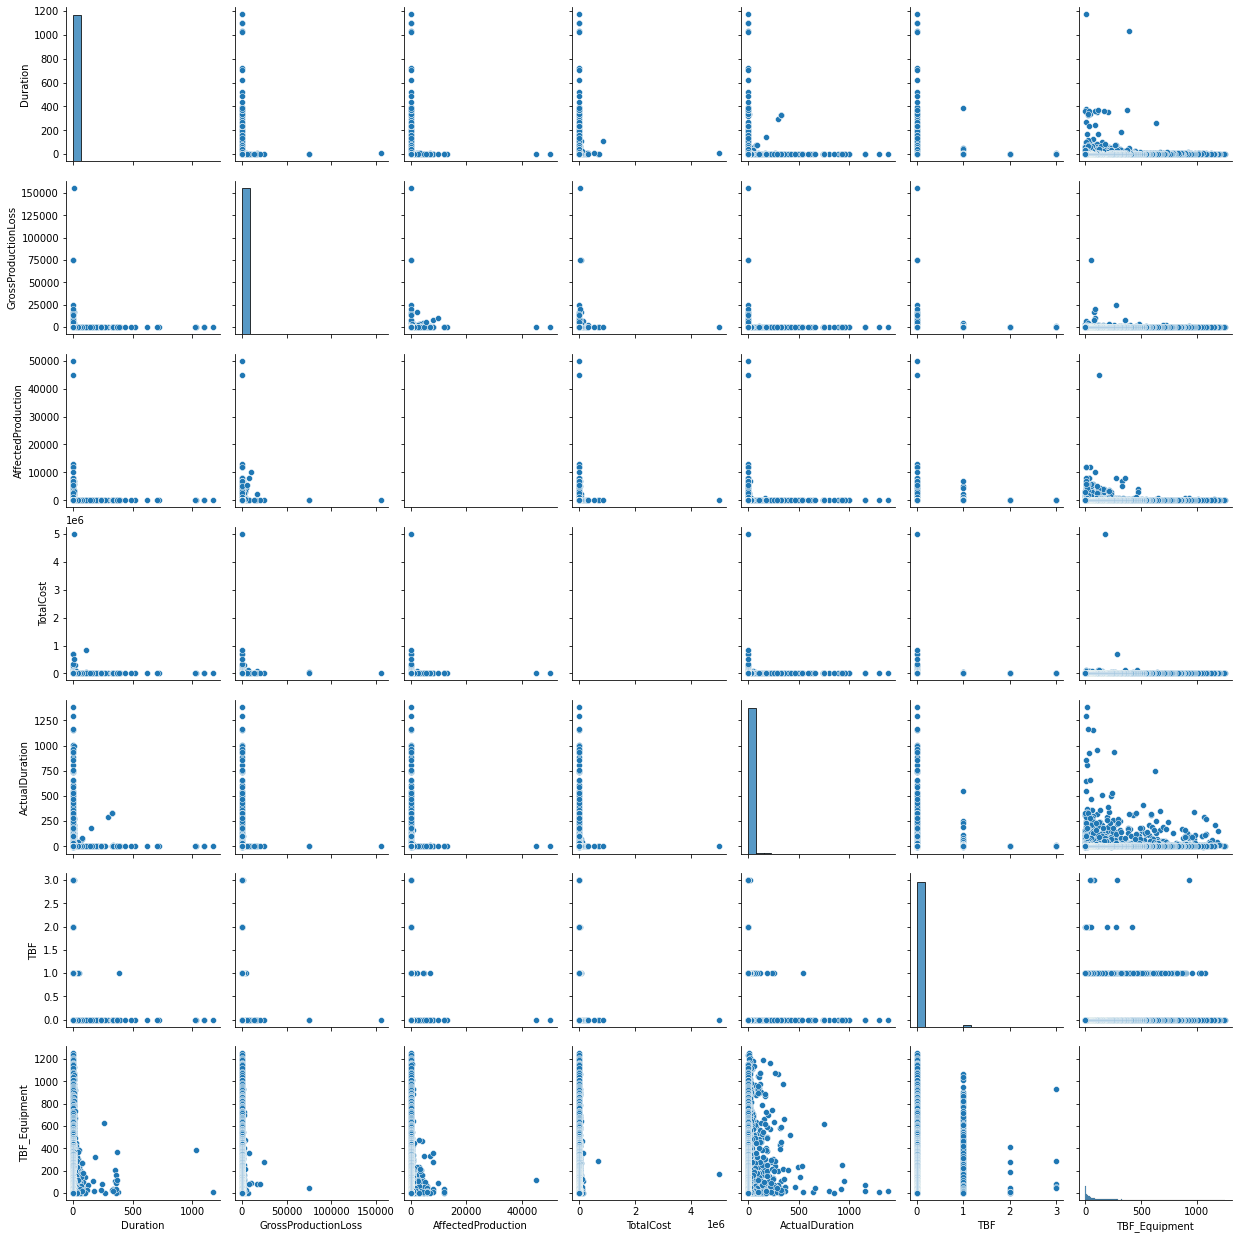

In [ ]:
sns.pairplot(data = datasetFiltered, dropna = True)

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Encode non-numerical columns to numerical
# -----------------------------------------------------------------------------------------------------------------    
datasetEncode = pd.DataFrame(data=None, columns=datasetFiltered.columns)
label_encoder = preprocessing.LabelEncoder()
numericalColumns = datasetEncode._get_numeric_data().columns

for column in datasetFiltered.columns:
    if column not in numericalColumns:
        datasetEncode[column] = label_encoder.fit_transform(datasetFiltered[column])
print(datasetEncode)

In [ ]:
datasetFiltered.describe()

,Duration,GrossProductionLoss,AffectedProduction,TotalCost,ActualDuration,TBF,TBF_Equipment
count,89480.000000,89480.000000,89480.000000,8.948000e+04,89480.000000,89480.000000,43698.000000
mean,1.979001,15.377347,17.170586,7.245155e+02,1.495451,0.014126,124.043297
std,12.657583,661.908685,292.325789,1.767736e+04,20.174754,0.121373,168.194937
min,1.000000,0.000000,0.000000,0.000000e+00,-4.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,14.000000
50%,1.000000,0.000000,0.000000,2.330000e+02,0.000000,0.000000,56.000000
75%,1.000000,0.000000,5.000000,6.022500e+02,0.000000,0.000000,168.000000
max,1171.000000,156000.000000,50000.000000,5.010670e+06,1384.000000,3.000000,1253.000000


In [ ]:
dfmean=datasetFiltered[["TotalCost","ActualDuration","TBF"]].mean()
print(dfmean)

TotalCost         724.515512
ActualDuration      1.495451
TBF                 0.014126
dtype: float64


In [ ]:
dfstd=datasetFiltered[["TotalCost","ActualDuration","TBF"]].std()
print(dfstd)

TotalCost         17677.358268
ActualDuration       20.174754
TBF                   0.121373
dtype: float64


In [ ]:
dfmin=datasetFiltered[["TotalCost","ActualDuration","TBF"]].min()
print(dfmin)

TotalCost         0
ActualDuration   -4
TBF               0
dtype: int64


In [ ]:
dfmax=datasetFiltered[["TotalCost","ActualDuration","TBF"]].max()
print(dfmax)

TotalCost         5010670
ActualDuration       1384
TBF                     3
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7d452f8d0>,
      dtype=object)

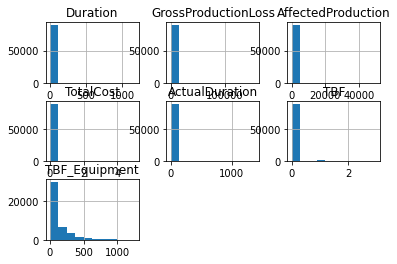

In [ ]:
datasetFiltered.hist()


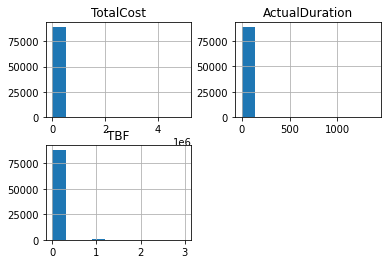

In [ ]:
dfhist=datasetFiltered[["TotalCost","ActualDuration","TBF"]].hist()

In [ ]:
datasetFiltered.TotalCost.quantile([0.2,0.8])


0.2      0.0
0.8    742.0
Name: TotalCost, dtype: float64

In [ ]:
datasetFiltered.TBF.quantile([0.8,0.2])


0.8    0.0
0.2    0.0
Name: TBF, dtype: float64

In [ ]:
datasetFiltered.TBF.quantile(.2)


0.0

In [ ]:
datasetFiltered['cumulative_sum'] = datasetFiltered.TBF.cumsum()
datasetFiltered['cumulative_perc'] = 100*datasetFiltered.cumulative_sum/datasetFiltered.TBF.sum()

In [ ]:
df['cumulative_sum'] = df.total.cumsum()
df['cumulative_perc'] = 100*df.cumulative_sum/df.total.sum()

# PCA

# Machine Learning CatBoost

In [ ]:
df.drop(columns=['WorkOrder', 'Comment', 'EquipmentCode', 'EquipmentRollupCode', 'EquipmentDescription', 'StatusCode', 'StatusDescription', 
                 'StatusShortDescription', 'WOType', 'JobType', 'Action', 'Requirement', 'LaborCost', 'MaterialCost', 'Assigned', 'Trade', 
                 'TradeGroup', 'SupervisorRole', 'Model', 'CreatedBy', 'UpdatedBy', 'CreatedDate', 'UpdatedDate', 'ReportDate', 
                 'ReportMonth', 'ReportWeekDay', 'TargetDate', 'SchEndDate', 'ScheduleCompliant', 'PMOverdue', 'CompletedDate', 
                 'CompletedMonth', 'CompletedWeekDay'], inplace = True)

df = df.fillna(0)

df['Class1'] = np.where(df['Duration'] > 7, df['Duration'], 1)
df['Class0'] = np.where(df['Class1'] <= 7, df['Class1'], 0)
df['Class2'] = np.where(df['TotalCost'] > 6520, df['TotalCost'], 1)
df['Class3'] = np.where(df['Class2'] <= 6520, df['Class2'], 0)
df['Class4'] = np.where(df['TBF_Equipment'] > 40, df['TBF_Equipment'], 1)
df['Class5'] = np.where(df['Class4'] <= 40, df['Class4'], 0)

## Duration

In [ ]:
y_true = df['Class0']
X = df.drop(['TBF', 'Duration', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

cat_features = ['FieldProductionTeam', 'EquipmentType', 'EquipmentClass',
       'EquipmentCriticality', 'Cause', 'FailureReason', 'IsAffectingProduction', 
       'Manufacturer', 'Safety', 'Reopened']

In [ ]:
model = CatBoostClassifier(random_state=1110, eval_metric='F1')

In [ ]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
metrics.f1_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

In [ ]:
cm2 = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(cm2,annot=True)

## Total Cost

In [ ]:
y_true = df['Class3']
X = df.drop(['TBF_Equipment', 'TBF', 'GrossProductionLoss', 'AffectedProduction', 'TotalCost', 'Duration', 'ActualDuration', 
             'Class1', 'Class2', 'Class0', 'Class4', 'Class5'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

cat_features = ['FieldProductionTeam', 'EquipmentType', 'EquipmentClass',
       'EquipmentCriticality', 'Cause', 'FailureReason', 'IsAffectingProduction', 
       'Manufacturer', 'Safety', 'Reopened']

In [ ]:
model = CatBoostClassifier(random_state=1110, eval_metric='F1')

In [ ]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
metrics.f1_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

In [ ]:
cm2 = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(cm2,annot=True)

## Time between reports

In [ ]:
y_true = df['Class5']
X = df.drop(['TBF_Equipment', 'TBF', 'GrossProductionLoss', 'AffectedProduction', 'TotalCost', 'Duration', 'ActualDuration', 
             'Class1', 'Class2', 'Class0', 'Class4', 'Class3'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

cat_features = ['FieldProductionTeam', 'EquipmentType', 'EquipmentClass',
       'EquipmentCriticality', 'Cause', 'FailureReason', 'IsAffectingProduction', 
       'Manufacturer', 'Safety', 'Reopened']

In [ ]:
model = CatBoostClassifier(random_state=1110, eval_metric='F1')

In [ ]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
metrics.f1_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

In [ ]:
cm2 = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(cm2,annot=True)

# Conclusion and lessons learned

The machine learning algorthm said in Duration, Total Cost and Time between reports that we have 0 False Negatives and 0 False Positive. So, the threshold in each variable is 1.


*   Duration: The algorithm predicted that everything is above 7 days
*   Total cost: The algorithm predicted that everything is above $6,520.00
*   TBF: The algorithm predicted that everything is above 40 days.

One less

